In [3]:
import tensorflow as tf
print(tf.__version__)

2.0.0


# Model subclassing and custom training loops

 ## Coding tutorials
 #### [1. Model subclassing](#coding_tutorial_1)
 #### [2. Custom layers](#coding_tutorial_2)
 #### [3. Automatic differentiation](#coding_tutorial_3)
 #### [4. Custom training loops](#coding_tutorial_4)
 #### [5. tf.function decorator](#coding_tutorial_5)

***
<a id="coding_tutorial_1"></a>
## Model subclassing

In [4]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Softmax, concatenate

#### Create a simple model using the model subclassing API

In [5]:
# Build the model

class MyModel(Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.dense1 = Dense(64, activation='relu')
        self.dense2 = Dense(10)
        self.dense3 = Dense(5)
        self.softmax = Softmax()
        
    def call(self, inputs, training=True):
        x = self.dense1(inputs)
        y1 = self.dense2(inputs)
        y2 = self.dense3(y1)
            
        concat = concatenate([x, y2])
        return self.softmax(concat)

In [6]:
# Print the model summary

model = MyModel()
model(tf.random.uniform([1,10]))
model.summary()

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  704       
_________________________________________________________________
dense_1 (Dense)              multiple                  110       
_________________________________________________________________
dense_2 (Dense)              multiple                  55        
_________________________________________________________________
softmax (Softmax)            multiple                  0         
Total params: 869
Trainable params: 869
Non-trainable params: 0
_________________________________________________________________


***
<a id="coding_tutorial_2"></a>
## Custom layers

In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Softmax

#### Create custom layers

In [8]:
# Create a custom layer

class Mylayer(Layer):
    def __init__(self, units, input_dim):
        super(Mylayer, self).__init__()
        self.w = self.add_weight(shape=(input_dim, units),
                                initializer='random_normal')
        self.b = self.add_weight(shape=(units,),
                                initializer='zeros')
        
    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b
    
dense_layer = Mylayer(3, 5)
x = tf.ones((1,5))
print(dense_layer(x))
print(dense_layer.weights)

tf.Tensor([[0.0391518  0.14233944 0.09729359]], shape=(1, 3), dtype=float32)
[<tf.Variable 'Variable:0' shape=(5, 3) dtype=float32, numpy=
array([[ 0.05897384,  0.08555096,  0.03022622],
       [-0.03831163,  0.03687225,  0.05212485],
       [-0.0262162 , -0.03121616,  0.01322009],
       [ 0.00623552,  0.00379783, -0.00640558],
       [ 0.03847028,  0.04733456,  0.00812803]], dtype=float32)>, <tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>]


In [9]:
# Specify trainable weights

class Mylayer(Layer):
    def __init__(self, units, input_dim):
        super(Mylayer, self).__init__()
        self.w = self.add_weight(shape=(input_dim, units),
                                initializer='random_normal',
                                trainable=False)
        self.b = self.add_weight(shape=(units,),
                                 trainable=False,
                                 initializer='zeros')
        
    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b
    
dense_layer = Mylayer(3, 5)

In [10]:
print('trainable weights:', len(dense_layer.trainable_weights))
print('non-trainable weights:', len(dense_layer.non_trainable_weights))

trainable weights: 0
non-trainable weights: 2


In [11]:
# Create a custom layer to accumulate means of output values

class MylayerMean(Layer):
    
    def __init__(self, units, input_dim):
        super(MylayerMean, self).__init__()
        self.w = self.add_weight(shape=(input_dim, units),
                                initializer='random_normal')
        self.b = self.add_weight(shape=(units,),
                                initializer='zeros')
        self.sum_activation = tf.Variable(initial_value=tf.zeros((units,)),
                                         trainable=False)
        self.number_call = tf.Variable(initial_value=0,
                                         trainable=False)
    def call(self, inputs):
        activations = tf.matmul(inputs, self.w)+self.b
        self.sum_activation.assign_add(tf.reduce_sum(activations, axis=0))
        self.number_call.assign_add(inputs.shape[0])
        return activations, self.sum_activation / tf.cast(self.number_call, tf.float32)
    
dense_layer = MylayerMean(3, 5)

In [12]:
# Test the layer

y, activation_means = dense_layer(tf.ones((1, 5)))
print(activation_means.numpy())

[-0.0510953   0.00037754 -0.08105041]


In [13]:
# Create a Dropout layer as a custom layer

class MyDropout(Layer):

    def __init__(self, rate):
        super(MyDropout, self).__init__()
        self.rate = rate
        
    def call(self, inputs):
        # Define forward pass for dropout layer
        return tf.nn.dropout(inputs, rate=self.rate)

#### Implement the custom layers into a model

In [14]:
# Build the model using custom layers with the model subclassing API

class MyModel(Model):

    def __init__(self, units_1, input_dim_1, units_2, units_3):
        super(MyModel, self).__init__()
        # Define layers
        self.layer_1 = Mylayer(units_1, input_dim_1)
        self.dropout_1 = MyDropout(0.5)
        self.layer_2 = Mylayer(units_2, units_1)
        self.dropout_2 = MyDropout(0.5)
        self.layer_3 = Mylayer(units_3, units_2)
        self.softmax = Softmax()
            
            
    def call(self, inputs):
        # Define forward pass
        
        x = self.layer_1(inputs)
        x = tf.nn.relu(x)
        x = self.dropout_1(x)
        x = self.layer_2(x)
        x = tf.nn.relu(x)
        x = self.dropout_2(x)
        x = self.layer_3(x)
        
        return self.softmax(x)
    

In [15]:
# Instantiate a model object

model = MyModel(64,10000,64,46)
print(model(tf.ones((1, 10000))))
model.summary()

tf.Tensor(
[[0.01721045 0.02879125 0.01814832 0.01200931 0.01873488 0.03335699
  0.02203406 0.0219726  0.02480232 0.03577311 0.026233   0.02488943
  0.01569154 0.02025833 0.01909051 0.02534655 0.02236231 0.01990625
  0.01864088 0.01554067 0.0291322  0.01875726 0.01787923 0.02008217
  0.02814357 0.0257905  0.01828696 0.02354221 0.01792619 0.01622616
  0.01726088 0.02596387 0.03238271 0.02141479 0.02126496 0.01752366
  0.02418213 0.01916969 0.02333448 0.01544415 0.01862931 0.01547165
  0.02693495 0.02523289 0.02339519 0.01583544]], shape=(1, 46), dtype=float32)
Model: "my_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mylayer_2 (Mylayer)          multiple                  640064    
_________________________________________________________________
my_dropout (MyDropout)       multiple                  0         
_________________________________________________________________
mylayer_3 (Mylayer

***
<a id="coding_tutorial_3"></a>
## Automatic differentiation

In [16]:
import numpy as np
import matplotlib.pyplot as plt

#### Create synthetic data

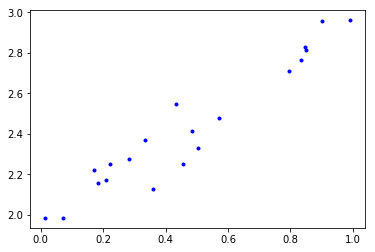

In [17]:
# Create data from a noise contaminated linear model

def MakeNoisyData(m, b, n=20):
    x = tf.random.uniform(shape=(n,))
    noise = tf.random.normal(shape=(len(x),), stddev=0.1)
    y = m * x + b + noise
    return x, y

m=1
b=2
x_train, y_train = MakeNoisyData(m,b)
plt.plot(x_train, y_train, 'b.')

#### Define a linear regression model

In [18]:
from tensorflow.keras.layers import Layer

In [20]:
# Build a custom layer for the linear regression model

class LinearLayer(Layer):
    
    def __init__(self):
        super(LinearLayer, self).__init__()
        self.m = self.add_weight(shape=(1,),
                                initializer='random_normal')
        self.b = self.add_weight(shape=(1,),
                                initializer='zeros')
        
    def call(self, inputs):
        return self.m*inputs+self.b

linear_regression = LinearLayer()

print(linear_regression(x_train))
print(linear_regression.weights)

tf.Tensor(
[0.01204293 0.00036505 0.00892584 0.00547266 0.01128591 0.00704801
 0.0041971  0.02461024 0.01422677 0.02240198 0.01253732 0.00518549
 0.00832707 0.0018035  0.02107352 0.02075217 0.01974917 0.00454431
 0.01076748 0.02114796], shape=(20,), dtype=float32)
[<tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([0.02484629], dtype=float32)>, <tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]


#### Define the loss function

In [21]:
# Define the mean squared error loss function

def SquaredError(y_pred, y_true):
    return tf.reduce_mean(tf.square(y_pred - y_true)) 

starting_loss = SquaredError(linear_regression(x_train), y_train)
print("Starting loss", starting_loss.numpy())

Starting loss 5.938137


#### Train and plot the model

In [24]:
# Implement a gradient descent training loop for the linear regression model

learning_rate = 0.5
steps = 25

for i in range(steps):
    
    with tf.GradientTape() as tape:
        predictions = linear_regression(x_train)
        loss = SquaredError(predictions, y_train)
        
    gradients = tape.gradient(loss, linear_regression.trainable_variables)
    
    linear_regression.m.assign_sub(learning_rate * gradients[0])
    linear_regression.b.assign_sub(learning_rate * gradients[1])
        
    print(f"step {i}, loss {loss.numpy()}")

step 0, loss 0.0071754977107048035
step 1, loss 0.007175222039222717
step 2, loss 0.007174982223659754
step 3, loss 0.007174777332693338
step 4, loss 0.007174596190452576
step 5, loss 0.00717443972826004
step 6, loss 0.007174313068389893
step 7, loss 0.007174192927777767
step 8, loss 0.00717409560456872
step 9, loss 0.007174001540988684
step 10, loss 0.007173924241214991
step 11, loss 0.007173864636570215
step 12, loss 0.007173807360231876
step 13, loss 0.007173755671828985
step 14, loss 0.007173721678555012
step 15, loss 0.007173682563006878
step 16, loss 0.0071736471727490425
step 17, loss 0.007173621095716953
step 18, loss 0.007173595484346151
step 19, loss 0.007173576857894659
step 20, loss 0.007173553109169006
step 21, loss 0.007173542864620686
step 22, loss 0.007173528429120779
step 23, loss 0.00717351445928216
step 24, loss 0.007173507008701563


m:1,  trained m:[0.99075854]
b:2,  trained b:[1.959083]


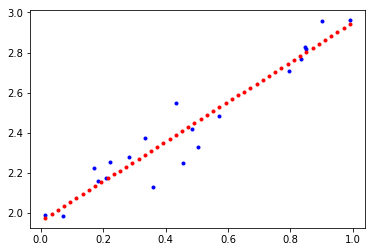

In [25]:
# Plot the learned regression model

print("m:{},  trained m:{}".format(m,linear_regression.m.numpy()))
print("b:{},  trained b:{}".format(b,linear_regression.b.numpy()))

plt.plot(x_train, y_train, 'b.')

x_linear_regression=np.linspace(min(x_train), max(x_train),50)
plt.plot(x_linear_regression, linear_regression.m*x_linear_regression+linear_regression.b, 'r.')

***
<a id="coding_tutorial_4"></a>
## Custom training loops

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import time

#### Build the model

In [27]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Softmax

In [53]:
# Define the custom layers and model

class Mylayer(Layer):
    def __init__(self, units):
        super(Mylayer, self).__init__()
        self.units = units
        
    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
                                initializer='random_normal',
                                name='kernel')
        self.b = self.add_weight(shape=(self.units,),
                                initializer='zeros',
                                name='bias')
        
    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b
    
class MyDropout(Layer):

    def __init__(self, rate):
        super(MyDropout, self).__init__()
        self.rate = rate
        
    def call(self, inputs):
        # Define forward pass for dropout layer
        return tf.nn.dropout(inputs, rate=self.rate)
    
class MyModel(Model):

    def __init__(self, units_1, units_2, units_3):
        super(MyModel, self).__init__()
        # Define layers
        self.layer_1 = Mylayer(units_1)
        self.dropout_1 = MyDropout(0.5)
        self.layer_2 = Mylayer(units_2)
        self.dropout_2 = MyDropout(0.5)
        self.layer_3 = Mylayer(units_3)
        self.softmax = Softmax()
            
    def call(self, inputs):
        # Define forward pass
        
        x = self.layer_1(inputs)
        x = tf.nn.relu(x)
        x = self.dropout_1(x)
        x = self.layer_2(x)
        x = tf.nn.relu(x)
        x = self.dropout_2(x)
        x = self.layer_3(x)
        
        return self.softmax(x)
    

In [54]:
model = MyModel(64, 64, 46)
print(model(tf.ones((1, 10000))))
model.summary()

tf.Tensor(
[[0.03124814 0.02484335 0.02293538 0.04040133 0.05875756 0.00901441
  0.02693157 0.02344201 0.00788057 0.02890745 0.01569841 0.02722865
  0.02728042 0.01708805 0.01903956 0.01536807 0.01428998 0.01555389
  0.01356581 0.0173677  0.00947416 0.01129262 0.01065379 0.00723018
  0.03126108 0.03346773 0.00538929 0.02134461 0.01607403 0.03061992
  0.01111625 0.01347009 0.01171407 0.03201464 0.03150545 0.01181193
  0.01222527 0.02518844 0.013632   0.03183133 0.02716058 0.03414245
  0.03455855 0.02850702 0.01379752 0.03367474]], shape=(1, 46), dtype=float32)
Model: "my_model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mylayer_5 (Mylayer)          multiple                  640064    
_________________________________________________________________
my_dropout_2 (MyDropout)     multiple                  0         
_________________________________________________________________
mylayer_6 (Mylayer

#### Load the reuters dataset and define the class_names 

In [68]:
# Load the dataset

from tensorflow.keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

class_names = ['cocoa','grain','veg-oil','earn','acq','wheat','copper','housing','money-supply',
   'coffee','sugar','trade','reserves','ship','cotton','carcass','crude','nat-gas',
   'cpi','money-fx','interest','gnp','meal-feed','alum','oilseed','gold','tin',
   'strategic-metal','livestock','retail','ipi','iron-steel','rubber','heat','jobs',
   'lei','bop','zinc','orange','pet-chem','dlr','gas','silver','wpi','hog','lead']

In [69]:
# Print the class of the first sample

print("Label: {}".format(class_names[train_labels[0]]))
train_data.shape, train_labels.shape

Label: earn


((8982,), (8982,))

#### Get the dataset word index

In [70]:
# Load the Reuters word index

word_to_index = reuters.get_word_index()

invert_word_index = dict([(value, key) for (key, value) in word_to_index.items()])
text_news = ' '.join([invert_word_index.get(i - 3, '?') for i in train_data[0]])

In [71]:
# Print the first data example sentence

print(text_news)

? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


#### Preprocess the data

In [72]:
# Define a function that encodes the data into a 'bag of words' representation

def bag_of_words(text_samples, elements=10000):
    output = np.zeros((len(text_samples), elements))
    for i, word in enumerate(text_samples):
        output[i, word] = 1.
    return output

x_train = bag_of_words(train_data)
x_test = bag_of_words(test_data)

print("Shape of x_train:", x_train.shape)
print("Shape of x_test:", x_test.shape)

Shape of x_train: (8982, 10000)
Shape of x_test: (2246, 10000)


#### Define the loss function and optimizer



In [73]:
# Define the categorical cross entropy loss and Adam optimizer

loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

def loss(model, x, y, wd):
    kernel_variables = []
    for l in model.layers:
        for w in l.weights:
            if 'kernel' in w.name:
                kernel_variables.append(w)
    wd_penalty = wd * tf.reduce_sum([tf.reduce_sum(tf.square(k)) for k in kernel_variables])
    y_ = model(x)
    return loss_object(y_true=y, y_pred=y_) + wd_penalty

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

#### Train the model

In [61]:
# Define a function to compute the forward and backward pass

def grad(model, inputs, targets, wd):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, wd)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [62]:
# Implement the training loop

from tensorflow.keras.utils import to_categorical

start_time = time.time()

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, train_labels))
train_dataset = train_dataset.batch(32)

train_loss_results = []
train_accuracy_results = []

num_epochs = 10
weight_decay = 0.005

for epoch in range(num_epochs):
    
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()
    
    for x, y in train_dataset:
        loss_value, grads = grad(model, x, y, weight_decay)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
        epoch_loss_avg(loss_value)
        epoch_accuracy(to_categorical(y), model(x))
        
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())
    
    print(f'Epoch: {epoch}, Loss: {epoch_loss_avg.result()}, ACC: {epoch_accuracy.result()}')
        
    
print("Duration :{:.3f}".format(time.time() - start_time))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch: 0, Loss: 3.2929556369781494, ACC: 0.4943219721317291
Epoch: 1, Loss: 1.9151376485824585, ACC: 0.6116677522659302
Epoch: 2, Loss: 1.8210625648498535, ACC: 0.647071897983551
Epoch: 3, Loss: 1.8006377220153809, ACC: 0.6703406572341919
Epoch: 4, Loss: 1.751587986946106, ACC: 0.6828100681304932
Epoch: 5, Loss: 1.7415167093276978, ACC: 0.6894900798797607
Epoch: 6, Loss: 1.7255148887634277, ACC: 0.6965041160583496
Epoch: 7, Loss: 1.7085483074188232, ACC: 0.6969494819641113
Epoch: 8, Loss: 1.726003170013

#### Evaluate the model

In [63]:
# Create a Dataset object for the test set

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, test_labels))
test_dataset = test_dataset.batch(32)

In [64]:
# Collect average loss and accuracy

epoch_loss_avg = tf.keras.metrics.Mean()
epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()

In [65]:
# Loop over the test set and print scores

from tensorflow.keras.utils import to_categorical

for x, y in test_dataset:
    # Optimize the model
    loss_value = loss(model, x, y, weight_decay)    
    # Compute current loss
    epoch_loss_avg(loss_value)  
    # Compare predicted label to actual label
    epoch_accuracy(to_categorical(y), model(x))

print("Test loss: {:.3f}".format(epoch_loss_avg.result().numpy()))
print("Test accuracy: {:.3%}".format(epoch_accuracy.result().numpy()))

Test loss: 1.837
Test accuracy: 66.696%


#### Plot the learning curves

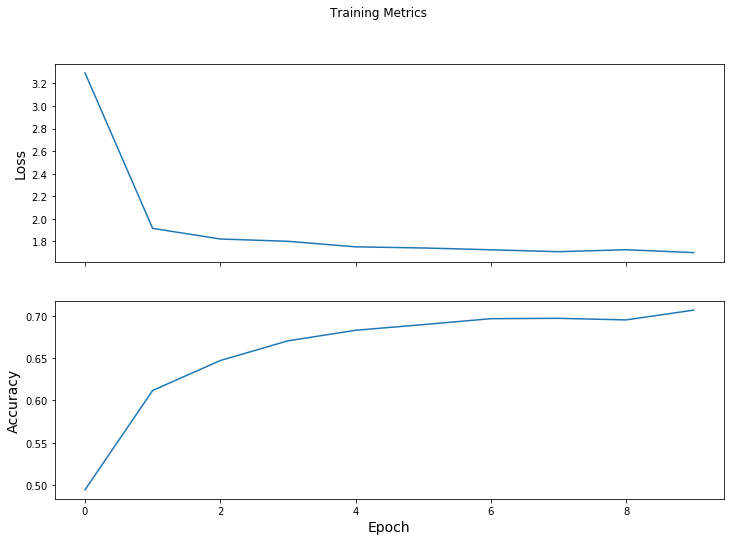

In [66]:
# Plot the training loss and accuracy

fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

#### Predict from the model

In [67]:
# Get the model prediction for an example input

predicted_label = np.argmax(model(x_train[np.newaxis,0]),axis=1)[0]
print("Prediction: {}".format(class_names[predicted_label]))
print("     Label: {}".format(class_names[train_labels[0]]))

Prediction: earn
     Label: earn


***
<a id="coding_tutorial_5"></a>
## tf.function decorator

In [74]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Softmax
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import reuters
import numpy as np
import matplotlib.pyplot as plt
import time

#### Build the model

In [75]:
# Initialize a new model

model = MyModel(64, 64, 46)

#### Redefine the grad function using the @tf.function decorator

In [76]:
# Use the @tf.function decorator

@tf.function
def grad(model, inputs, targets, wd):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, wd)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

#### Train the model

In [77]:
# Re-run the training loop

from tensorflow.keras.utils import to_categorical

start_time = time.time()

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, train_labels))
train_dataset = train_dataset.batch(32)

train_loss_results = []
train_accuracy_results = []

num_epochs = 10
weight_decay = 0.005

for epoch in range(num_epochs):
    
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()
    
    for x, y in train_dataset:
        loss_value, grads = grad(model, x, y, weight_decay)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
        epoch_loss_avg(loss_value)
        epoch_accuracy(to_categorical(y), model(x))
        
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())
    
    print(f'Epoch: {epoch}, Loss: {epoch_loss_avg.result()}, ACC: {epoch_accuracy.result()}')
        
    
print("Duration :{:.3f}".format(time.time() - start_time))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch: 0, Loss: 3.299794912338257, ACC: 0.47851258516311646
Epoch: 1, Loss: 1.9129680395126343, ACC: 0.6276998519897461
Epoch: 2, Loss: 1.8215972185134888, ACC: 0.6639946699142456
Epoch: 3, Loss: 1.7721366882324219, ACC: 0.6828100681304932
Epoch: 4, Loss: 1.7555632591247559, ACC: 0.6934981346130371
Epoch: 5, Loss: 1.7346514463424683, ACC: 0.6989534497261047
Epoch: 6, Loss: 1.714933156967163, ACC: 0.7016254663467407
Epoch: 7, Loss: 1.706869125366211, ACC: 0.7054108381271362
Epoch: 8, Loss: 1.703140616416

#### Print the autograph code

In [78]:
# Use tf.autograph.to_code to see the generated code

print(tf.autograph.to_code(grad.python_function))

def tf__grad(model, inputs, targets, wd):
  do_return = False
  retval_ = ag__.UndefinedReturnValue()
  with ag__.FunctionScope('grad', 'grad_scope', ag__.ConversionOptions(recursive=True, user_requested=True, optional_features=(), internal_convert_user_code=True)) as grad_scope:
    with tf.GradientTape() as tape:
      loss_value = ag__.converted_call(loss, grad_scope.callopts, (model, inputs, targets, wd), None, grad_scope)
    do_return = True
    retval_ = grad_scope.mark_return_value((loss_value, ag__.converted_call(tape.gradient, grad_scope.callopts, (loss_value, model.trainable_variables), None, grad_scope)))
  do_return,
  return ag__.retval(retval_)

